In [1]:
%matplotlib widget
import numpy as np
import torch
from scipy.integrate import simps
import scipy.stats as stats

In [2]:
from FourierGridMethod import Fourier_Grid,normalize_wfn,side_wp
from Generate_fields import random_perturbation
from potfields import potential,electric_field,alpha,complete_simulation,chirped_pulse
from new_split import split_op
from plot_utils import animate_dyn,plot_eig,plot_perturbation,plot_wavepacket,plot_field_2d
from bayesian import likelihood,pop_i,prior

In [3]:
# Define the acceptance function
def acceptance(current_params, prop_params,x_grid,y_grid,param_1_prior,param_2_prior,param_3_prior,pot_params):
    """
    Calculates the acceptance probability for the proposed parameter values.
    """
    
    sig=0.8
    t0=2.0
    
    k_curr= current_params[0]
    k1_curr= current_params[1]
    t_curr=current_params[2]
    
    k_prop=prop_params[0]
    k1_prop=prop_params[1]
    t_prop=prop_params[2]
    
    curr_f_params= {'sig':sig,'t0':t0,'t1':t_curr,'k':k_curr,'k1':k1_curr}
    prop_f_params= {'sig':sig,'t0':t0,'t1':t_prop,'k':k_prop,'k1':k1_prop}
    
    task='mcmc'
    curr_score=complete_simulation(task,x_grid,y_grid,pot_params,curr_f_params)
    current_likelihood = likelihood(curr_score)

    prop_score=complete_simulation(task,x_grid,y_grid,pot_params,prop_f_params)
    proposed_likelihood = likelihood(prop_score)
    
    prior_current = np.prod([param_1_prior.pdf(current_params[0]), param_2_prior.pdf(current_params[1]),param_2_prior.pdf(current_params[2])])
    prior_proposed = np.prod([param_1_prior.pdf(prop_params[0]), param_2_prior.pdf(prop_params[1]),param_2_prior.pdf(prop_params[2])])
    
    #prior_current = prior(range_1,range_2)
    #prior_proposed = prior(range_1,range_2)
    
    return min(1, (proposed_likelihood * prior_proposed) / (current_likelihood * prior_current)),prop_score,curr_score

In [4]:
#Setting variables for the simulation
#the hamiltonian for the system is 

# Define the x and y coordinates of the grid

x_min, x_max = -90*np.pi/180, 90*np.pi/180
y_min, y_max = 0, 7.25
x_size, y_size = 128, 128

#Define x and y grids
x_grid = np.linspace(x_min, x_max, x_size)
y_grid = np.linspace(y_min, y_max, y_size)

#Define meshgrid terms for 3D plots and making perturbations
x_dim, t_dim = np.meshgrid(x_grid, y_grid)

In [5]:
#rng = np.random.RandomState(seed=123)
nstates=20
    
#Scale for unit conversion to au
ev_scale=1/(27*1e3)
    
#Generate the double well potential
V_pot=potential(x_grid,y_grid)

#scale and plot
V_mev=ev_scale*(V_pot)
    
#Values for inertia 
IBr=8911925
IF=1864705

#Calculate Irel
Irel=(IBr*IF)/(IBr+IF)
    
#coherence and variance in amplitude for term1
phi_coh_x = 12.2
phi_coh_y = 0.27
phi_amp_var=11.9
    
#Generate the n_v term and plot it. This term is in mev
phi_perturb=random_perturbation(x_size,y_size,phi_coh_x,phi_coh_y,phi_amp_var)
    
V_vib=V_pot+phi_perturb
V_vib_ev=ev_scale*(V_vib)
    
#Generate the alpha term
alpha_1=np.vectorize(alpha)(x_grid)
        
#FGH at step 0 and normalisation
E0,psi0=Fourier_Grid(Irel,x_size,x_max-x_min,V_vib_ev[0])
psi0=normalize_wfn(psi0,x_grid,nstates)

#FGH at step t and normalisation
Et,psit=Fourier_Grid(Irel,x_size,x_max-x_min,V_vib_ev[y_size-1])
psit=normalize_wfn(psi0,x_grid,nstates)
    
psi_start=side_wp(psi0,-1)
psi_ref=side_wp(psit,1)
    
pot_params={'psi_start':psi_start,'psi_ref':psi_ref,'V_vib':V_vib,'alpha':alpha_1, 'I_rel': Irel}


0.0017708019961055039
0.0017708019961055039


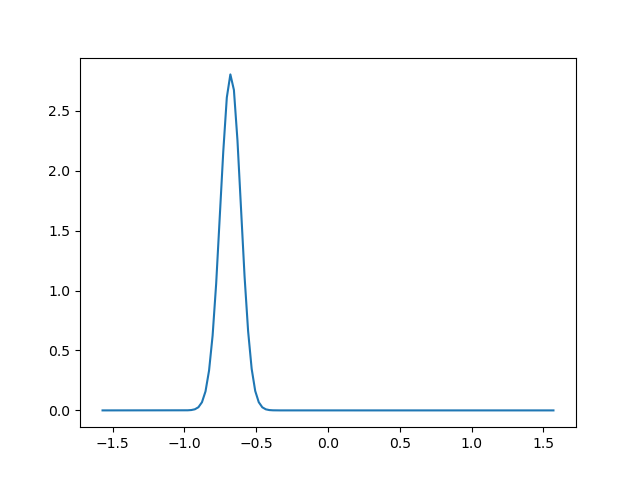

In [34]:
import matplotlib.pyplot as plt
plt.clf()
plt.plot(x_grid,psi_start)
plt.show()


In [35]:
psi_ref=np.concat(psi_start[64:],psi_start[0,64])
plt.clf()
plt.plot(x_grid,-psi_ref)
plt.show()


AttributeError: module 'numpy' has no attribute 'concat'

ERROR:tornado.application:Exception in callback <bound method TimerBase._on_timer of <matplotlib.backends.backend_webagg_core.TimerTornado object at 0x14a134a06be0>>
Traceback (most recent call last):
  File "/p/software/juwelsbooster/stages/2022/software/Jupyter/2022.3.4-gcccoremkl-11.2.0-2021.4.0/lib/python3.9/site-packages/tornado/ioloop.py", line 921, in _run
    val = self.callback()
  File "/p/software/juwelsbooster/stages/2022/software/matplotlib/3.4.3-gcccoremkl-11.2.0-2021.4.0/lib/python3.9/site-packages/matplotlib/backend_bases.py", line 1216, in _on_timer
    ret = func(*args, **kwargs)
  File "/p/software/juwelsbooster/stages/2022/software/matplotlib/3.4.3-gcccoremkl-11.2.0-2021.4.0/lib/python3.9/site-packages/matplotlib/animation.py", line 1477, in _step
    still_going = super()._step(*args)
  File "/p/software/juwelsbooster/stages/2022/software/matplotlib/3.4.3-gcccoremkl-11.2.0-2021.4.0/lib/python3.9/site-packages/matplotlib/animation.py", line 1189, in _step
    self._

In [13]:
# Set up the initial parameter values and the number of MCMC iterations
n_iterations = 5000 # number of MCMC iterations
burn_in = 500

#Generate electric field
#A0 = 1.0                      # Peak amplitude #Variable range (1,5)
#t0 = 3.5                      # Center time #fixed
#sigma = 1               # Standard deviation #variable (0.5,2)
#f0 = 5                      # Central frequency #variable (2,5)
#beta = 0.1                    # Chirp rate fixed 



param_1 = 1.5 # initial value for the first field parameter A0
param_2 = 2.0 # initial value for the second field parameter sig
param_3=2 #initial value of third parameter 
params = [param_1, param_2,param_3] # current parameter values

# Define the range bounds for the parameters
param_1_bounds = [2, 5]
param_2_bounds = [2, 5]
param_3_bounds = [2,6]

#print(*stats.norm.fit(param_1_bounds),np.std(param_1_bounds),np.mean(param_1_bounds))
#mu1,std1=stats.norm.fit(param_1_bounds)
# Define the prior distribution for the field parameters
param_1_prior = stats.truncnorm((param_1_bounds[0] - np.mean(param_1_bounds)) / np.std(param_1_bounds),
                                (param_1_bounds[1] - np.mean(param_1_bounds)) / np.std(param_1_bounds),
                                loc=np.mean(param_1_bounds),
                                scale=np.std(param_1_bounds))
param_2_prior = stats.truncnorm((param_2_bounds[0] - np.mean(param_2_bounds)) / np.std(param_2_bounds),
                                (param_2_bounds[1] - np.mean(param_2_bounds)) / np.std(param_2_bounds),
                                loc=np.mean(param_2_bounds),
                                scale=np.std(param_2_bounds))
param_3_prior = stats.truncnorm((param_3_bounds[0] - np.mean(param_3_bounds)) / np.std(param_3_bounds),
                                (param_3_bounds[1] - np.mean(param_3_bounds)) / np.std(param_3_bounds),
                                loc=np.mean(param_3_bounds),
                                scale=np.std(param_3_bounds))

# Initialize the acceptance counter
accept_counter = 0

# Initialize the parameter trace
param_trace = np.zeros((n_iterations, 3))
score_trace = np.zeros((n_iterations))

# Perform the MCMC iterations
for i in range(n_iterations):
    # Propose new parameter values
    proposed_params = prior(param_1_prior,param_2_prior,param_3_prior)
    
    if i%500 ==0 :
        print("Number of iterations",i)
    
    # Calculate the acceptance probability
    acceptance_prob,prop_score,curr_score = acceptance(params, proposed_params,x_grid,y_grid,param_1_prior,param_2_prior,param_3_prior,pot_params)
    
    # Accept or reject the proposal
    if np.random.uniform() < acceptance_prob:
        params = proposed_params # accept the proposal
        choose_score=prop_score
        accept_counter += 1
    else:
        params = params # reject the proposal
        choose_score=curr_score
    
    # Record the current parameter values
    param_trace[i,:] = params
    score_trace[i]=choose_score

Number of iterations 0


/tmp/ipykernel_11977/2719115001.py:34: RuntimeWarning: divide by zero encountered in double_scalars
  return min(1, (proposed_likelihood * prior_proposed) / (current_likelihood * prior_current)),prop_score,curr_score


Number of iterations 500
Number of iterations 1000
Number of iterations 1500
Number of iterations 2000
Number of iterations 2500
Number of iterations 3000
Number of iterations 3500
Number of iterations 4000
Number of iterations 4500


ERROR:tornado.application:Exception in callback <bound method TimerBase._on_timer of <matplotlib.backends.backend_webagg_core.TimerTornado object at 0x14a13471c880>>
Traceback (most recent call last):
  File "/p/software/juwelsbooster/stages/2022/software/Jupyter/2022.3.4-gcccoremkl-11.2.0-2021.4.0/lib/python3.9/site-packages/tornado/ioloop.py", line 921, in _run
    val = self.callback()
  File "/p/software/juwelsbooster/stages/2022/software/matplotlib/3.4.3-gcccoremkl-11.2.0-2021.4.0/lib/python3.9/site-packages/matplotlib/backend_bases.py", line 1216, in _on_timer
    ret = func(*args, **kwargs)
  File "/p/software/juwelsbooster/stages/2022/software/matplotlib/3.4.3-gcccoremkl-11.2.0-2021.4.0/lib/python3.9/site-packages/matplotlib/animation.py", line 1477, in _step
    still_going = super()._step(*args)
  File "/p/software/juwelsbooster/stages/2022/software/matplotlib/3.4.3-gcccoremkl-11.2.0-2021.4.0/lib/python3.9/site-packages/matplotlib/animation.py", line 1189, in _step
    self._

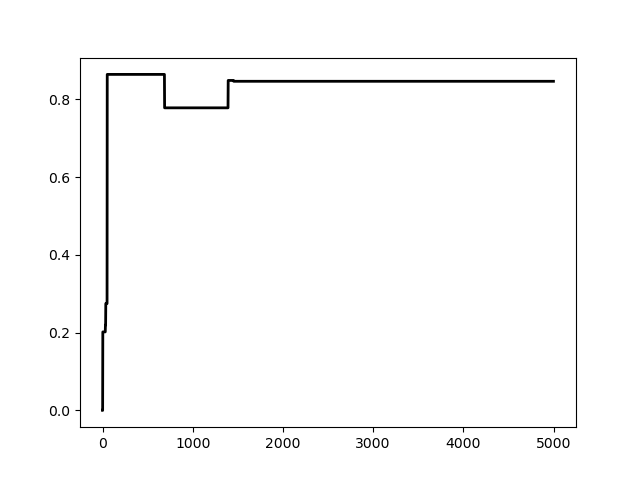

ERROR:tornado.application:Exception in callback <bound method TimerBase._on_timer of <matplotlib.backends.backend_webagg_core.TimerTornado object at 0x14a13471c880>>
Traceback (most recent call last):
  File "/p/software/juwelsbooster/stages/2022/software/Jupyter/2022.3.4-gcccoremkl-11.2.0-2021.4.0/lib/python3.9/site-packages/tornado/ioloop.py", line 921, in _run
    val = self.callback()
  File "/p/software/juwelsbooster/stages/2022/software/matplotlib/3.4.3-gcccoremkl-11.2.0-2021.4.0/lib/python3.9/site-packages/matplotlib/backend_bases.py", line 1216, in _on_timer
    ret = func(*args, **kwargs)
  File "/p/software/juwelsbooster/stages/2022/software/matplotlib/3.4.3-gcccoremkl-11.2.0-2021.4.0/lib/python3.9/site-packages/matplotlib/animation.py", line 1477, in _step
    still_going = super()._step(*args)
  File "/p/software/juwelsbooster/stages/2022/software/matplotlib/3.4.3-gcccoremkl-11.2.0-2021.4.0/lib/python3.9/site-packages/matplotlib/animation.py", line 1189, in _step
    self._

In [30]:
import matplotlib.pyplot as plt
plt.clf()
x=np.arange(0,n_iterations)
plt.plot(x, score_trace, ls="-", c="k", lw=2, label="$score$")
plt.show()

In [15]:
# Define the thinning factor
thin_factor = 10

#remove the burn in samples
param_trace=param_trace[burn_in::]
# Thin the parameter trace
thinned_trace = param_trace[::thin_factor]

kde = stats.gaussian_kde(thinned_trace.T)
print(max(score_trace))

0.8641730432055649


In [17]:
x_range = np.linspace(2, 5, 200)
y_range = np.linspace(2, 5, 200)
p_range = np.linspace(2, 6, 200)

# Evaluate the posterior distribution on the range of values
xx, yy,pp = np.meshgrid(x_range, y_range,p_range)
pos = np.vstack([xx.ravel(), yy.ravel(), pp.ravel()])
z = np.reshape(kde(pos).T, xx.shape)

# Find the maximum of the posterior distribution
max_idx = np.argmax(z)
max_x = pos[0][max_idx]
max_y = pos[1][max_idx]
max_pp = pos[2][max_idx]
max_z = z.ravel()[max_idx]

# # Plot the posterior distribution
# fig, ax = plt.subplots()
# ax.contourf(xx, yy, z, cmap='Blues')
# ax.set_xlabel('Parameter 1')
# ax.set_ylabel('Parameter 2')
# ax.set_title('Posterior Distribution')

In [18]:
print(max_x,max_y,max_pp,max_z)

4.849246231155779 4.0954773869346734 2.5829145728643215 357.2804679676892


In [20]:
# max_x=4.5
# max_y=5
# max_pp=0.1
sigma=1
t0=3.5

#Generate electric field
#A0 = 1.0                      # Peak amplitude #Variable range (1,5)
#t0 = 3.5                      # Center time #fixed
#sigma = 1               # Standard deviation #variable (0.5,2)
#f0 = 5                      # Central frequency #variable (2,5)
#beta = 0.1                    # Chirp rate fixed 

    
k_curr= max_x
k1_curr= max_y
t_curr=max_pp
phi=np.pi

#chirped_pulse(t_dim, k, t0, sig, k1, t1, phi)
prop_f_params= {'sig':sigma,'t0':t0,'t1':t_curr,'k':k_curr,'k1':k1_curr}
best_f=chirped_pulse(t_dim,k_curr,t0,sigma,k1_curr,t_curr,phi)
task='sagen'    
p=complete_simulation(task,x_grid,y_grid,pot_params,prop_f_params)

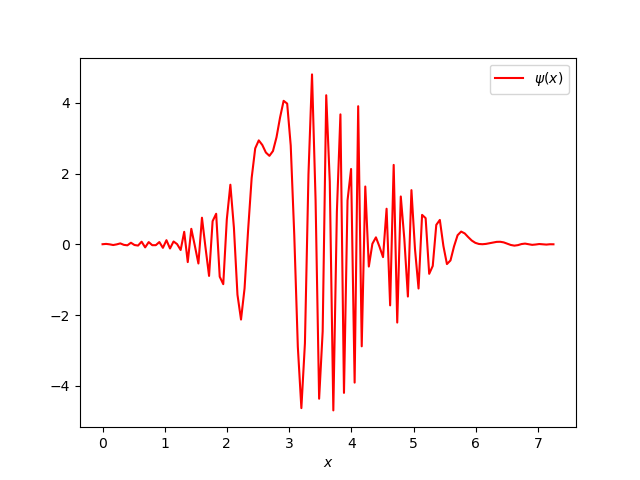

In [21]:
import matplotlib.pyplot as plt
plt.clf()
plot_field_2d(y_grid,best_f)

In [22]:
task='gen'    
a,b,c,d=complete_simulation(task,x_grid,y_grid,pot_params,prop_f_params)

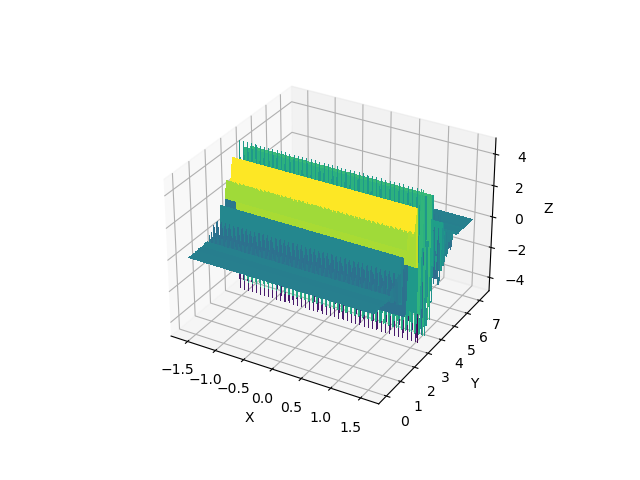

In [23]:
#%matplotlib inline
plot_laser=plot_perturbation(x_grid,y_grid,best_f)

In [24]:
print(p)

0.6775476019630607


ERROR:tornado.application:Exception in callback <bound method TimerBase._on_timer of <matplotlib.backends.backend_webagg_core.TimerTornado object at 0x14a13471c880>>
Traceback (most recent call last):
  File "/p/software/juwelsbooster/stages/2022/software/Jupyter/2022.3.4-gcccoremkl-11.2.0-2021.4.0/lib/python3.9/site-packages/tornado/ioloop.py", line 921, in _run
    val = self.callback()
  File "/p/software/juwelsbooster/stages/2022/software/matplotlib/3.4.3-gcccoremkl-11.2.0-2021.4.0/lib/python3.9/site-packages/matplotlib/backend_bases.py", line 1216, in _on_timer
    ret = func(*args, **kwargs)
  File "/p/software/juwelsbooster/stages/2022/software/matplotlib/3.4.3-gcccoremkl-11.2.0-2021.4.0/lib/python3.9/site-packages/matplotlib/animation.py", line 1477, in _step
    still_going = super()._step(*args)
  File "/p/software/juwelsbooster/stages/2022/software/matplotlib/3.4.3-gcccoremkl-11.2.0-2021.4.0/lib/python3.9/site-packages/matplotlib/animation.py", line 1189, in _step
    self._

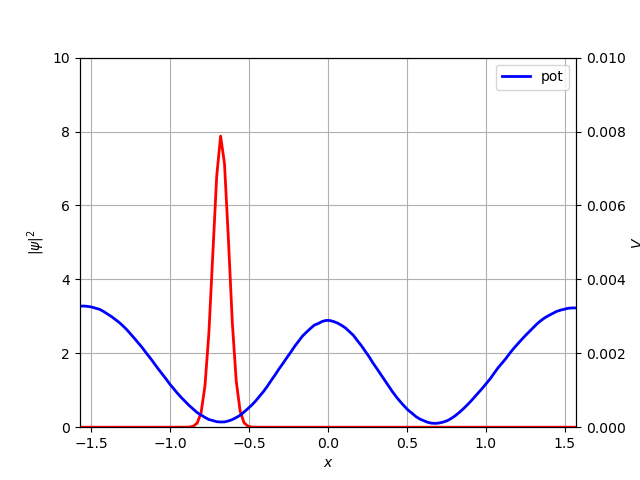

ERROR:tornado.application:Exception in callback <bound method TimerBase._on_timer of <matplotlib.backends.backend_webagg_core.TimerTornado object at 0x14a13471c880>>
Traceback (most recent call last):
  File "/p/software/juwelsbooster/stages/2022/software/Jupyter/2022.3.4-gcccoremkl-11.2.0-2021.4.0/lib/python3.9/site-packages/tornado/ioloop.py", line 921, in _run
    val = self.callback()
  File "/p/software/juwelsbooster/stages/2022/software/matplotlib/3.4.3-gcccoremkl-11.2.0-2021.4.0/lib/python3.9/site-packages/matplotlib/backend_bases.py", line 1216, in _on_timer
    ret = func(*args, **kwargs)
  File "/p/software/juwelsbooster/stages/2022/software/matplotlib/3.4.3-gcccoremkl-11.2.0-2021.4.0/lib/python3.9/site-packages/matplotlib/animation.py", line 1477, in _step
    still_going = super()._step(*args)
  File "/p/software/juwelsbooster/stages/2022/software/matplotlib/3.4.3-gcccoremkl-11.2.0-2021.4.0/lib/python3.9/site-packages/matplotlib/animation.py", line 1189, in _step
    self._

In [31]:

t=animate_dyn(x_min,x_max,0,100,x_grid,b,d)